In [30]:
# Ranking Board games
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import scipy.stats as st
import seaborn as sns

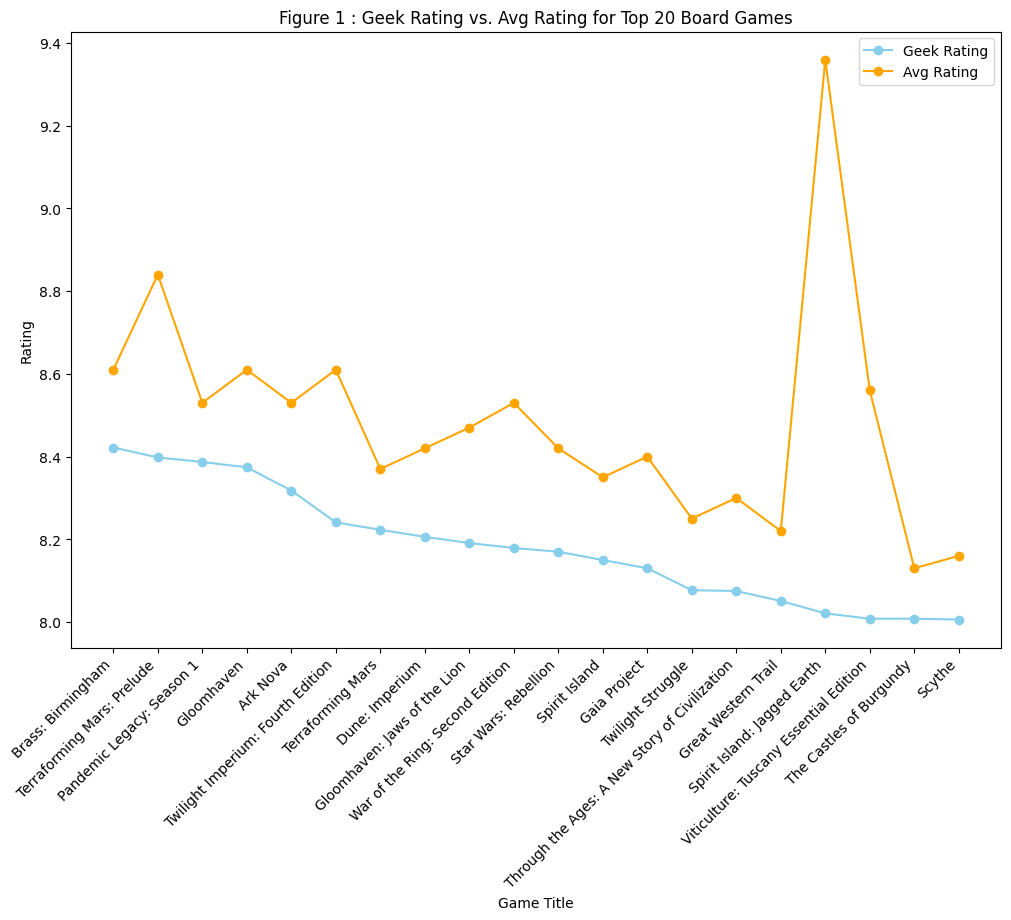

In [10]:
# Introduction example 
# Comparing Geek top 20 games (as of Friday 17th of November 2023) 

# Create Data frame with top 20 geek ranking games and their respective ratings
# Define the data
dt = {
    'g_ranking': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
    18, 19, 20],
    'title': [
        'Brass: Birmingham', 'Terraforming Mars: Prelude', 
        'Pandemic Legacy: Season 1', 'Gloomhaven', 'Ark Nova', 
        'Twilight Imperium: Fourth Edition', 'Terraforming Mars',
        'Dune: Imperium', 'Gloomhaven: Jaws of the Lion', 
        'War of the Ring: Second Edition','Star Wars: Rebellion', 
        'Spirit Island', 'Gaia Project', 'Twilight Struggle',
        'Through the Ages: A New Story of Civilization', 'Great Western Trail', 'Spirit Island: Jagged Earth',
        'Viticulture: Tuscany Essential Edition', 'The Castles of Burgundy', 
        'Scythe'
    ],
    'g_rating': [8.422, 8.398, 8.387, 8.374, 8.318, 8.241, 8.223, 8.206, 
    8.191, 8.179, 8.170, 8.150, 8.130, 8.077, 8.075, 8.051, 8.021, 8.008, 
    8.008, 8.006],
    'avg_rating': [8.61, 8.84, 8.53, 8.61, 8.53, 8.61, 8.37, 8.42, 8.47, 
    8.53, 8.42, 8.35, 8.40, 8.25, 8.30, 8.22, 9.36, 8.56, 8.13, 8.16],
    'num_voters': [41667, 14229, 51825, 60101, 36428, 22008, 93646, 39130, 
    31335, 20010, 30962, 47211, 25696, 47550, 30490, 39510, 4078, 9581, 59614, 79513]
}

# Create a DataFrame
geek_df = pd.DataFrame(dt)

# Sort the DataFrame by 'g_rating' in descending order to maintain the ranking
df_sorted = geek_df.sort_values(by='g_rating', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(df_sorted.head(20)['title'], df_sorted.head(20)['g_rating'], 
label='Geek Rating', marker='o', color='skyblue')
plt.plot(df_sorted.head(20)['title'], df_sorted.head(20)['avg_rating'], 
label='Avg Rating', marker='o', color='orange')
plt.xlabel('Game Title')
plt.ylabel('Rating')
plt.title('Figure 1 : Geek Rating vs. Avg Rating for Top 20 Board Games')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [11]:
bgg = pd.read_csv('bgg.csv')
summary = bgg.describe()
bgg = pd.DataFrame(bgg)
# Print the summary
print(summary)

               game         rating
count  1.082167e+06  706813.000000
mean   8.524701e+04       6.423427
std    8.958489e+04       1.907699
min    1.000000e+00       0.000000
25%    7.499000e+03       5.000000
50%    3.441900e+04       6.950000
75%    1.636400e+05       8.000000
max    3.101000e+05      10.000000


In [12]:
null_proportion = bgg['rating'].isnull().mean()
print('Proportion of Null Values in BGG dataset')
print(null_proportion)

Proportion of Null Values in BGG dataset
0.3468540437843697


### Proportion of Null Values in BGG dataset
0.3468540437843697

In [14]:
bgg['rating'] = bgg.groupby('game')['rating'].transform(lambda x: x.fillna(x.mean()))

# two board games have only written reviews with no ratings, we can drop these board game from our dataset 
bgg.dropna(subset=['rating'], inplace=True)

In [15]:
##Creating liked column 
bgg['liked'] = bgg['rating'].apply(lambda x: 1 if x >= 7.0 else 0)
bgg.to_csv('modified_bgg.csv', index=False)

mod_bgg = pd.read_csv('modified_bgg.csv')

In [24]:
import pandas as pd
import scipy.stats as st

# Wilson Score function
def wilson_score(pos, total, confidence=0.95):
    if total == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = pos / total
    return (phat + z*z / (2*total) - z * ((phat*(1-phat) + z*z / (4*total)) / total)**0.5) / (1 + z*z / total)

# Use group_by function
wilson_scores = bgg.groupby('game').apply(lambda x: wilson_score(x['liked'].sum(), len(x['liked'])))

print(wilson_scores)

game
1         0.744520
2         0.263642
3         0.801879
4         0.254615
5         0.744520
            ...   
305682    0.767199
306494    0.657953
306577    0.782020
308565    0.686059
310100    0.929988
Length: 23810, dtype: float64


/var/folders/bg/3lqzfh6x2njf4pdwqd44z7200000gn/T/ipykernel_37039/787240087.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wilson_scores = bgg.groupby('game').apply(lambda x: wilson_score(x['liked'].sum(), len(x['liked'])))


In [25]:
# Add the calculated Wilson scores to the DataFrame
wilson_df = pd.DataFrame({'game': wilson_scores.index, 
'wilson_score': wilson_scores.values})

wilson_df.to_csv('Wilson.Score.csv')


# Merge the Wilson scores back to the original DataFrame
wilson = pd.merge(mod_bgg, wilson_df, on='game')
wilson = pd.DataFrame(wilson)

# Step 1: Calculate average rating for each title by grouping by 'title'
average_rating_per_title = wilson.groupby('game')['rating'].mean().reset_index()
average_rating_per_title.columns = ['game', 'average_rating']

# Step 2: Create a new DataFrame with game, title, average rating, Wilson score
# Group by title and calculate the mean Wilson score for each title
wilson = wilson.groupby('game').agg({
    'title': 'first',  # Assuming 'game' is the same for each title
    'wilson_score': 'mean'
}).reset_index()

# Merge average rating into the grouped_df DataFrame
wilson = pd.merge(wilson, average_rating_per_title, on='game')

# Create a new column 'adjusted_wilson' by multiplying 'wilson_score' by 10
wilson['adjusted_wilson'] = wilson['wilson_score'] * 10

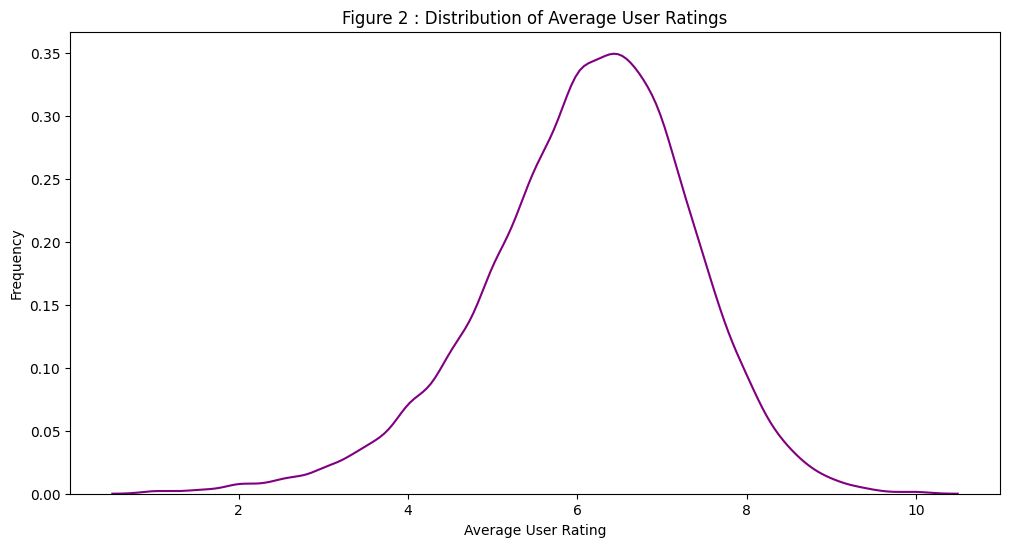

In [31]:
# create distribution of average rating
plt.figure(figsize=(12, 6))
sns.kdeplot(wilson['average_rating'], color='purple')
plt.xlabel('Average User Rating')
plt.ylabel('Frequency')
plt.title('Figure 2 : Distribution of Average User Ratings')
plt.show()

sum = wilson['average_rating'].describe()

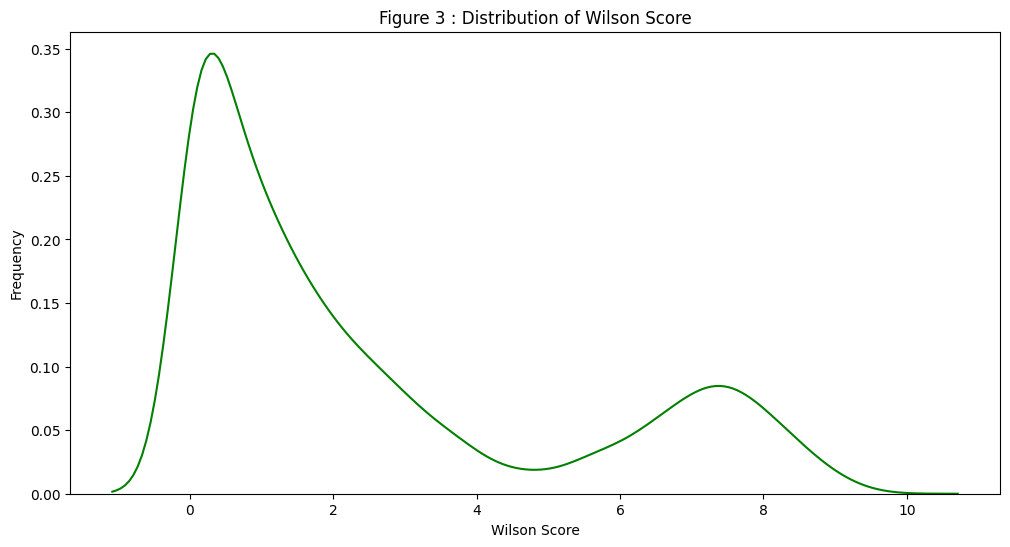

count    2.381000e+04
mean     2.518270e+00
std      2.704957e+00
min     -1.173174e-16
25%      3.852035e-01
50%      1.381201e+00
75%      3.751082e+00
max      9.630065e+00
Name: adjusted_wilson, dtype: float64


In [32]:
# create distribution of Wilson score
plt.figure(figsize=(12, 6))
sns.kdeplot(wilson['adjusted_wilson'], color='green')
plt.xlabel('Wilson Score')
plt.ylabel('Frequency')
plt.title('Figure 3 : Distribution of Wilson Score')
plt.show()

sum1 = wilson['adjusted_wilson'].describe()
print(sum1)

In [34]:
import seaborn as sns

# Sort the DataFrame by 'average_rating' and 'wilson_score'
sorted_by_rating = wilson.sort_values(by='average_rating', 
ascending=False)
sorted_by_wilson = wilson.sort_values(by='adjusted_wilson', 
ascending=False)


# Calculate the difference between adjusted Wilson score and average rating
wilson['score_difference'] = wilson['adjusted_wilson']-wilson['average_rating']

# Calculate the average difference
average_difference = wilson['score_difference'].mean()

print(f'Average Difference: {average_difference}')


Average Difference: -3.594562963761282


In [37]:
# Calculate the difference between adjusted Wilson score and average rating for top 20 games
top_20_avg = wilson.sort_values(by='average_rating', ascending=False).head(20)

# Check if the columns exist
if 'adjusted_wilson' in top_20_avg.columns and 'average_rating' in top_20_avg.columns:
    top_20_avg['score_difference'] = top_20_avg['adjusted_wilson'] - top_20_avg['average_rating']
    dif_top_20_avg = top_20_avg['score_difference'].mean()
    print(f'Average Difference (Top 20 Avg Rating): {dif_top_20_avg}')
else:
    print("Required columns are missing in the DataFrame.")

import pandas as pd

# Example DataFrame
data = {
    'game': ['A', 'B', 'C', 'D', 'E'],
    'adjusted_wilson': [0.8, 0.75, 0.9, 0.85, 0.7],
    'average_rating': [0.78, 0.72, 0.88, 0.84, 0.69]
}
wilson = pd.DataFrame(data)

def calculate_score_difference(df, top_n, ascending=False):
    # Sort and select top/bottom N games
    subset = df.sort_values(by='average_rating', ascending=ascending).head(top_n)

    # Check if the columns exist
    if 'adjusted_wilson' in subset.columns and 'average_rating' in subset.columns:
        subset['score_difference'] = subset['adjusted_wilson'] - subset['average_rating']
        avg_difference = subset['score_difference'].mean()
        return avg_difference
    else:
        print("Required columns are missing in the DataFrame.")
        return None

# Calculate differences for top games
top_20_avg = calculate_score_difference(wilson, 20, ascending=False)
top_200_avg = calculate_score_difference(wilson, 200, ascending=False)
top_2000_avg = calculate_score_difference(wilson, 2000, ascending=False)

# Calculate differences for bottom games
bottom_20_avg = calculate_score_difference(wilson, 20, ascending=True)
bottom_200_avg = calculate_score_difference(wilson, 200, ascending=True)
bottom_2000_avg = calculate_score_difference(wilson, 2000, ascending=True)

# Print results
print(f'Average Difference (Top 20 Avg Rating): {top_20_avg}')
print(f'Average Difference (Top 200 Avg Rating): {top_200_avg}')
print(f'Average Difference (Top 2000 Avg Rating): {top_2000_avg}')
print(f'Average Difference (Bottom 20 Avg Rating): {bottom_20_avg}')
print(f'Average Difference (Bottom 200 Avg Rating): {bottom_200_avg}')
print(f'Average Difference (Bottom 2000 Avg Rating): {bottom_2000_avg}')


Average Difference (Top 20 Avg Rating): -2.8762770150398422
Average Difference (Top 20 Avg Rating): 0.018000000000000016
Average Difference (Top 200 Avg Rating): 0.018000000000000016
Average Difference (Top 2000 Avg Rating): 0.018000000000000016
Average Difference (Bottom 20 Avg Rating): 0.018000000000000016
Average Difference (Bottom 200 Avg Rating): 0.018000000000000016
Average Difference (Bottom 2000 Avg Rating): 0.018000000000000016


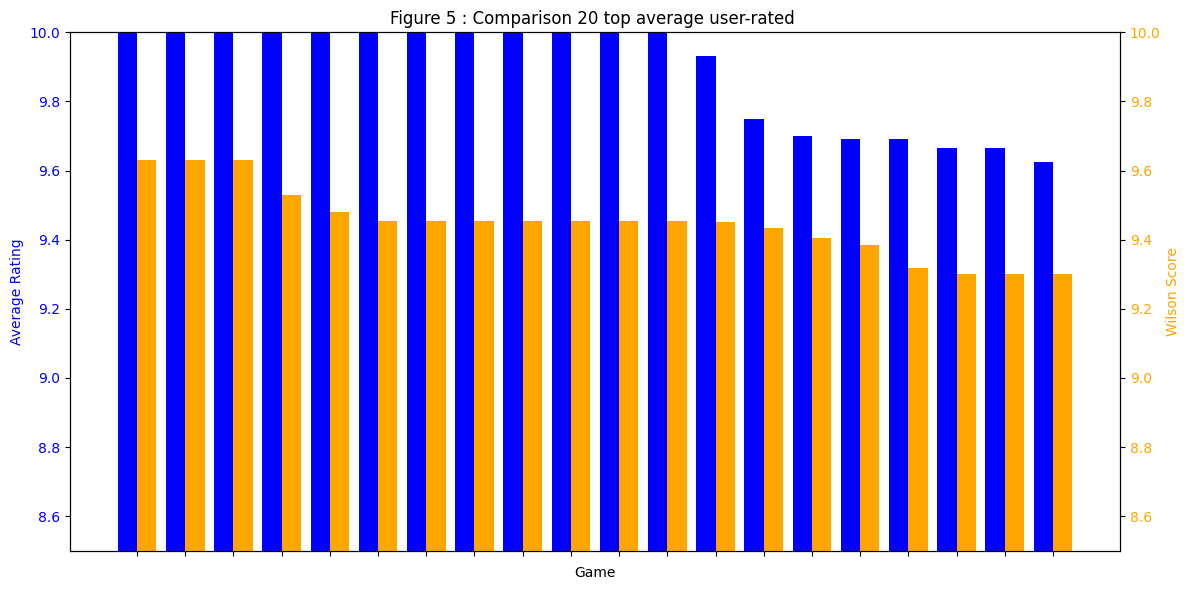

In [38]:
# Select top and bottom games for each criterion
a_20 = sorted_by_rating.head(20)
w_20 = sorted_by_wilson.head(20)


a_200 = sorted_by_rating.head(200)
w_200 = sorted_by_wilson.head(200)

# Top 20 
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.4
index = np.arange(len(a_20['game']))

# Plot bar chart for top average ratings on the primary y-axis
ax1.bar(index, a_20['average_rating'], width=bar_width, 
label='Top Avg Rating', color='blue')
ax1.set_xlabel('Game')
ax1.set_ylabel('Average Rating', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([])

# Set y-axis limits for top average ratings
ax1.set_ylim(8.5, 10)

# Create a secondary y-axis for top Wilson scores
ax2 = ax1.twinx()
ax2.bar(index + bar_width, w_20['adjusted_wilson'], width=bar_width, 
label='Top Wilson Score', color='orange')
ax2.set_ylabel('Wilson Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set y-axis limits for top Wilson scores
ax2.set_ylim(8.5, 10)

# Title and legend
plt.title('Figure 5 : Comparison 20 top average user-rated ')
fig.tight_layout()

# Show the plot
plt.show()

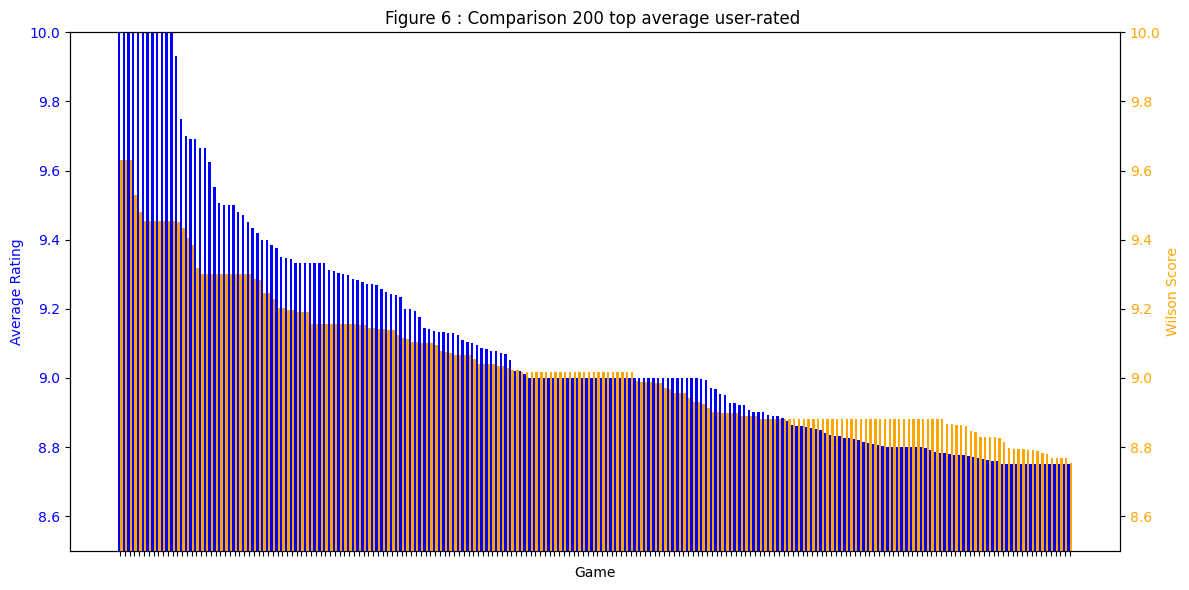

In [39]:
## Top 200 
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.5
index = np.arange(len(a_200['game']))

# Plot bar chart for top average ratings on the primary y-axis
ax1.bar(index, a_200['average_rating'], width=bar_width, 
label='Top Avg Rating', color='blue')
ax1.set_xlabel('Game')
ax1.set_ylabel('Average Rating', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([])

# Set y-axis limits for top average ratings
ax1.set_ylim(8.5, 10)

# Create a secondary y-axis for top Wilson scores
ax2 = ax1.twinx()
ax2.bar(index + bar_width, w_200['adjusted_wilson'], 
width=bar_width, label='Top Wilson Score', color='orange')
ax2.set_ylabel('Wilson Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set y-axis limits for top Wilson scores
ax2.set_ylim(8.5, 10)

# Title and legend
plt.title('Figure 6 : Comparison 200 top average user-rated ')
fig.tight_layout()

# Show the plot
plt.show()

In [40]:
# Get the minimum and maximum values of the bottom Wilson scores
Lw_2000 = sorted_by_wilson.tail(2000)
min_wilson_score = Lw_2000['adjusted_wilson'].min()
max_wilson_score = Lw_2000['adjusted_wilson'].max()

print(f"Minimum Lower Wilson Score: {min_wilson_score}")
print(f"Maximum Lower Wilson Score: {max_wilson_score}")


Minimum Lower Wilson Score: -1.1731740316366829e-16
Maximum Lower Wilson Score: 3.384324554477539e-16


Minimum Lower Wilson Score: -1.1731740316366829e-16
Maximum Lower Wilson Score: 3.384324554477539e-16

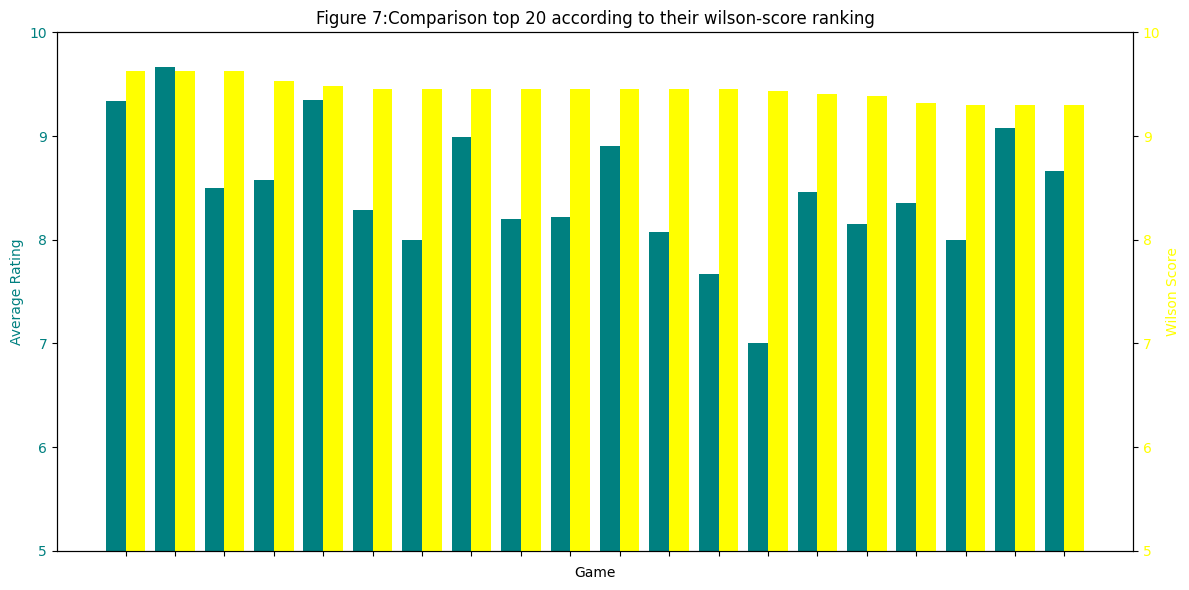

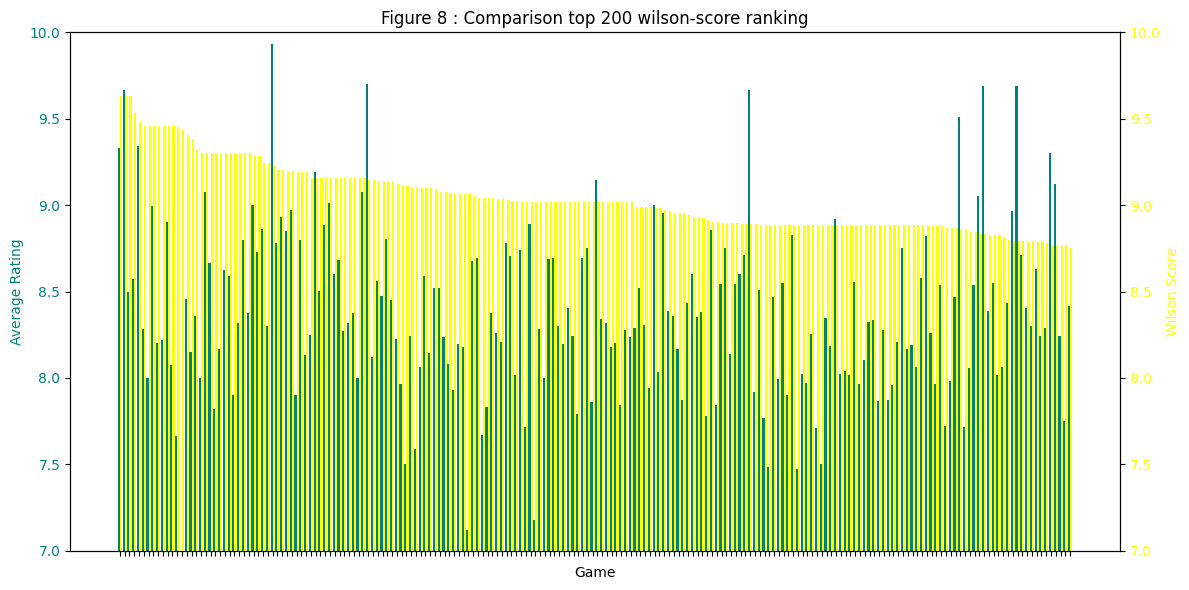

In [41]:
### Plotting the top 200 Board Games Ranking according their Wilson Scores, then comparing the same 200 games and their Average Ratings 

#Top 20 
# Create a figure and axis 
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.4
index = np.arange(len(w_20['game']))

# Plot bar chart for top average ratings on the primary y-axis, sorted by top Wilson scores
ax1.bar(index, w_20['average_rating'], width=bar_width, 
label='Top Avg Rating', color='teal')
ax1.set_xlabel('Game')
ax1.set_ylabel('Average Rating', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([])

# Set y-axis limits for top average ratings
ax1.set_ylim(5, 10)

# Create a secondary y-axis for top Wilson scores
ax2 = ax1.twinx()
ax2.bar(index + bar_width, w_20['adjusted_wilson'], 
width=bar_width, label='Top Wilson Score', color='yellow')
ax2.set_ylabel('Wilson Score', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')

# Set y-axis limits for top Wilson scores
ax2.set_ylim(5, 10)

# Title and legend
plt.title('Figure 7:Comparison top 20 according to their wilson-score ranking')
fig.tight_layout()

# Show the plot
plt.show()

##Top 200 
# Create a figure and axis 
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.45
index = np.arange(len(w_200['game']))

# Plot bar chart for top average ratings on the primary y-axis, sorted by top Wilson scores
ax1.bar(index, w_200['average_rating'], width=bar_width, 
label='Top Avg Rating', color='teal')
ax1.set_xlabel('Game')
ax1.set_ylabel('Average Rating', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([])

# Set y-axis limits for top average ratings
ax1.set_ylim(7, 10)

# Create a secondary y-axis for top Wilson scores
ax2 = ax1.twinx()
ax2.bar(index + bar_width, w_200['adjusted_wilson'], 
width=bar_width, label='Top Wilson Score', color='yellow')
ax2.set_ylabel('Wilson Score', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')

# Set y-axis limits for top Wilson scores
ax2.set_ylim(7, 10)

# Title and legend
plt.title('Figure 8 : Comparison top 200 wilson-score ranking')
fig.tight_layout()

# Show the plot
plt.show()